<a href="https://colab.research.google.com/github/areebunisa/casahpe/blob/main/casahpe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import skimage
from skimage import transform
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
import keras
from keras.utils import to_categorical,Sequence
from keras import applications
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,Input,MaxPooling2D,Conv2D,BatchNormalization,Activation
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.applications import resnet50, inception_resnet_v2, vgg16
from keras.applications.inception_resnet_v2 import preprocess_input
from keras import optimizers
from keras.optimizers import Adam,SGD
import os
from imutils import face_utils
import dlib
import cv2
import tarfile
from google.colab.patches import cv2_imshow
def to_rgb(img):
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
import math

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [14]:
!pip install -U -q PyDrive
!git clone https://github.com/Joshua1989/python_scientific_computing.git
!git clone https://gist.github.com/dc7e60aa487430ea704a8cb3f2c5d6a6.git /tmp/colab_util_repo
!mv /tmp/colab_util_repo/colab_util.py colab_util.py 
!rm -r /tmp/colab_util_repo

from colab_util import *
drive_handler = GoogleDriveHandler()

fatal: destination path 'python_scientific_computing' already exists and is not an empty directory.
Cloning into '/tmp/colab_util_repo'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), done.


In [15]:

!wget https://data.vision.ee.ethz.ch/cvl/gfanelli/downloads/db_annotations.tgz

--2021-01-08 01:24:15--  https://data.vision.ee.ethz.ch/cvl/gfanelli/downloads/db_annotations.tgz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 565563 (552K) [application/x-gzip]
Saving to: ‘db_annotations.tgz’

db_annotations.tgz  100%[===================>] 552.31K  1.15MB/s    in 0.5s    

2021-01-08 01:24:17 (1.15 MB/s) - ‘db_annotations.tgz’ saved [565563/565563]



In [16]:
tf = tarfile.open("db_annotations.tgz")
tf.extractall('annotations')

In [17]:
tf = tarfile.open("/content/gdrive/MyDrive/kinect_head_pose_db.tgz")
tf.extractall()

In [18]:
from os import walk
DATASET_PATH = 'hpdb'
def Loading_filepath(PATH):
    '''
    File directory generator.
    
    ---INPUT---
    
    PATH --- Directory to the dataset
    
    ---OUTPUT---
    
    jpgs --- list of path to images
    
    ** Made for loading BIWI dataset **
    
    '''
    jpgs = []
    for (dirpath,dirnames,filenames) in walk(PATH):
        for filename in filenames[:]:
            if(filename[-3:]=='png'):
                jpgs.append(dirpath+"/"+filename)
    return jpgs

In [19]:
!rm -r 'hpdb/01/frame_00003_rgb.png'


In [20]:
jpg_path = Loading_filepath(DATASET_PATH)
print("Dataset size: ",len(jpg_path))

Dataset size:  15677


In [21]:
pose = []
for i in range(len(jpg_path)):
    pose.append("annotations"+jpg_path[i][4:-7]+"pose.bin")
print("Pose parameter size: ",len(pose))

Pose parameter size:  15677


In [19]:
!rm -r crop_openpose


rm: cannot remove 'crop_openpose': No such file or directory


In [22]:
!mkdir crop_openpose

In [23]:
!wget http://dlib.net/files/mmod_human_face_detector.dat.bz2
!7z x "mmod_human_face_detector.dat.bz2"
detector = dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")

--2021-01-08 01:33:07--  http://dlib.net/files/mmod_human_face_detector.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694709 (678K)
Saving to: ‘mmod_human_face_detector.dat.bz2.4’

mmod_human_face_det 100%[===================>] 678.43K  1.53MB/s    in 0.4s    

2021-01-08 01:33:07 (1.53 MB/s) - ‘mmod_human_face_detector.dat.bz2.4’ saved [694709/694709]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 694709 bytes (679 KiB)

Extracting archive: mmod_human_face_detector.dat.bz2
--
Path = mmod_human_face_detector.dat.bz2
Type = bzip2


Would you like to replace the existing file:
  Path:     ./mmod_human_face_detector.dat
  Size:     7299

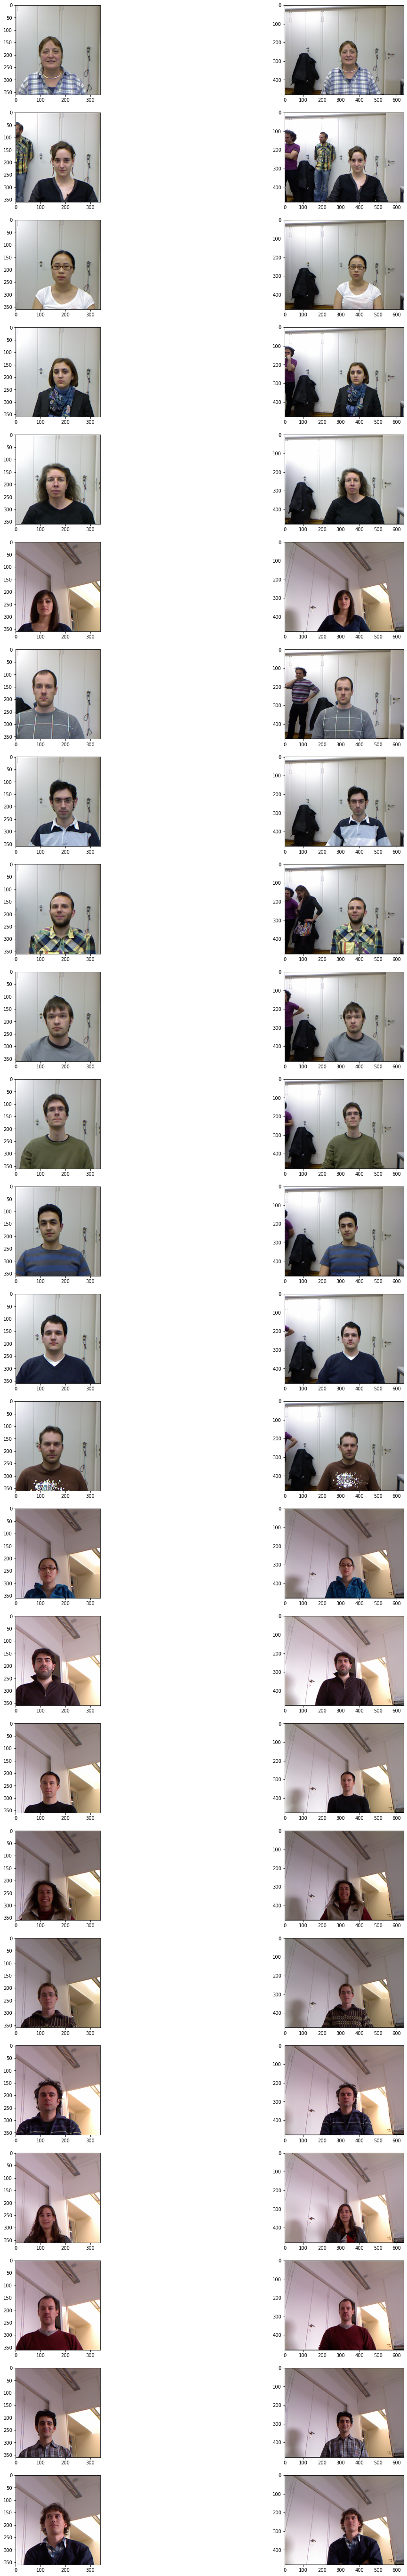

In [24]:
w=10
h=10
fig=plt.figure(figsize=(20, 100))
columns = 2
rows = 24
j = 1
k = 1
for i in range(1, columns*rows +1):
    if i%2 == 0:
        img = plt.imread("hpdb/" + "{:02d}".format(j) + "/frame_00005_rgb.png")
        j+=1
    else:
        img = plt.imread("hpdb/" + "{:02d}".format(k) + "/frame_00005_rgb.png")[65:-55,200:540]
        k+=1
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap = 'gray')
plt.show()


In [25]:
!for i in {01..24}; do mkdir 'crop_openpose/'${i} ;done


In [27]:
def GETCROPS(detector,jpg_path):
    '''
    File directory generator.
    
    ---INPUT---
    
    jpg-path --- List of image paths
    
    detector --- Dlib face detection dat file
    
    ---OUTPUT---
    
    All the crop images are saved
    
    ** Made for BIWI dataset **
    
    '''
    jpg_crop_path = []
    pyr = pd.DataFrame(columns = ['image','pitch','yaw','roll'])
    count = 0
    for i in range(len(jpg_path)):
        image = cv2.imread(jpg_path[i])[100:-75,200:540] #Reading images
        dets = detector(image, 0) # 0 is for not upsampling the image
        if len(dets) == 1: # Making sure that only one face is detected (as the images contain people in the background)
            crop_img = image[dets[0].rect.top()-15:dets[0].rect.bottom()+15,dets[0].rect.left()-15:dets[0].rect.right()+15] # cropping the image with 15 extra pixels on all side
            #crop_img = cv2.resize(crop_img,(96,96))
            cv2.imwrite("crop_openpose/" + jpg_path[i][5:] , crop_img) # writing the image to directory
            jpg_crop_path.append("crop_openpose/" + jpg_path[i][5:])
            count = count+1
        if i%1000 == 0:
            print(str(i) + " image reading done")
            print(str(count) + " image writing done")
    print(str(count) + " image written")
    return pyr

In [31]:
pyr = GETCROPS(detector,jpg_path)


0 image reading done
0 image writing done
1000 image reading done
853 image writing done
2000 image reading done
1853 image writing done


error: ignored

In [68]:
def GETCROPS(detector,jpg_path):
    '''
    File directory generator.
    
    ---INPUT---
    
    jpg-path --- List of image paths
    
    detector --- Dlib face detection dat file
    
    ---OUTPUT---
    
    All the crop images are saved
    
    ** Made for BIWI dataset **
    
    '''
    jpg_crop_path = []
    pyr = pd.DataFrame(columns = ['image','pitch','yaw','roll'])
    count = 0
    for i in range(len(jpg_path)):
        image = cv2.imread(jpg_path[i])[100:-75,200:540] #Reading images
        dets = detector(image, 0) # 0 is for not upsampling the image
        if len(dets) == 1: # Making sure that only one face is detected (as the images contain people in the background)
            crop_img = image[dets[0].rect.top()-15:dets[0].rect.bottom()+15,dets[0].rect.left()-15:dets[0].rect.right()+15] # cropping the image with 15 extra pixels on all side
            #crop_img = cv2.resize(crop_img,(96,96))
            cv2.imwrite("crop_openpose/" + jpg_path [i][5:] , crop_img) # writing the image to directory
            jpg_crop_path.append("crop_openpose/" + jpg_path[i][5:])
            count = count+1
        if i%1000 == 0:
            print(str(i) + " image reading done")
            print(str(count) + " image writing done")
    print(str(count) + " image written")
    return pyr

In [69]:
pyr = GETCROPS(detector,jpg_path)

0 image reading done
0 image writing done
1000 image reading done
853 image writing done
2000 image reading done
1853 image writing done


error: ignored

In [8]:
!apt-get install build-essential cmake
!apt-get install libopenblas-dev liblapack-dev 
!pip3 install dlib
!pip3 install face_recognition

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
liblapack-dev is already the newest version (3.7.1-4ubuntu1).
libopenblas-dev is already the newest version (0.2.20+ds-4).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


In [3]:
!pip install face_recognition

     |████████████████████████████████| 100.2MB 42kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=22688bc85c66d8a12b373dbb044d261cf1c556a655e6de75efd92489fcb02327
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models
